<a href="https://colab.research.google.com/github/Leon578/ReinforcementLearning/blob/main/LSTM_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
--- Starting Deposit Management Simulation (RNN-Based State) ---
Using device: cpu

--- Parameters ---
  Deposit_Type  Lifetime  Cost  Type_Index
0       Type_A        10   100           0
1       Type_B        20   250           1
2       Type_C        30   500           2
3       Type_D        40   750           3
4       Type_E        60  1000           4

Initial Records: 50, Initial Total Amount: 427,653.41
--------------------------------------------------

Initializing PPO Agent (RNN): Features=4, Embedding Dim=128, Action Dim=5
PPO Agent (RNN) created successfully.

Starting training for 3000 episodes...
Update trigger: 1024 steps. Batch: 128, Epochs: 8
Fitting scaler on data from first 20 episodes...
Fitting scaler on 312410 samples...
Scaler fit successfully.
Scaler Mean: [1.83206224e+01 6.70758298e+02 3.14843582e+03 2.65399955e+00]
Scaler Scale (StdDev): [1.44785304e+01 3.03937359e+02 4.21529230e+03 1.27333685e+00]
Ep 25/3000 | Avg R: 1.9 | Avg WCost: 670.3

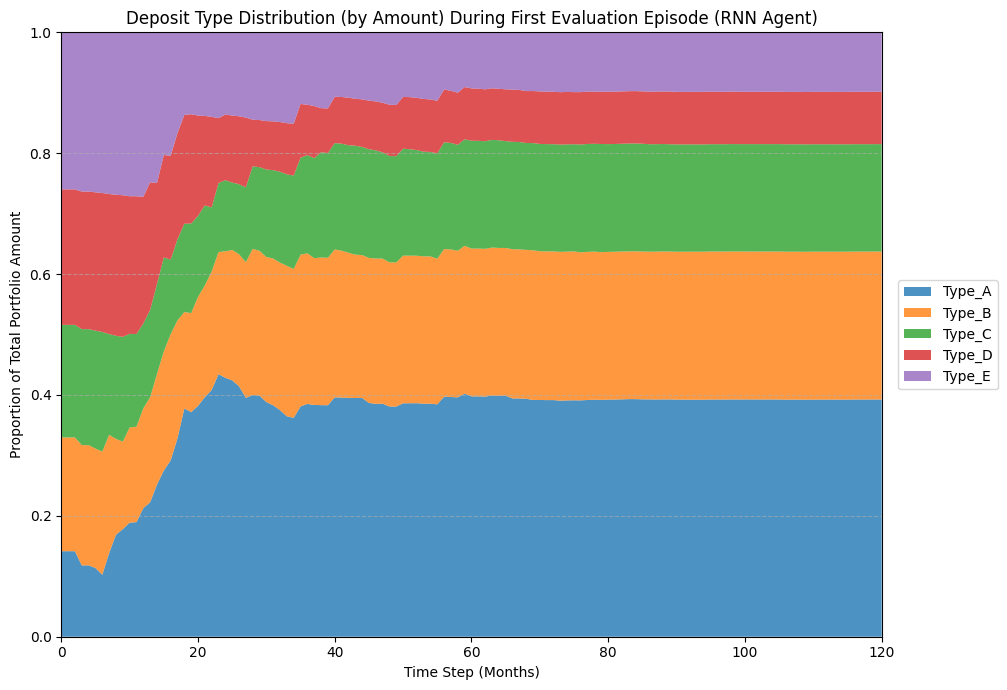

Environment closed.

--- Script Finished ---


In [1]:
# -*- coding: utf-8 -*-
# --- Imports ---
import pandas as pd
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Dirichlet
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
from typing import Tuple, Dict, List, Optional, Any, Union
import warnings
from sklearn.preprocessing import StandardScaler # For normalization

# --- Data Generation (No changes needed) ---

def create_parameters_df() -> pd.DataFrame:
    data = {
        'Deposit_Type': ['Type_A', 'Type_B', 'Type_C', 'Type_D', 'Type_E'],
        'Lifetime': [10, 20, 30, 40, 60], # Lifetimes in months (steps)
        'Cost': [100, 250, 500, 750, 1000] # Cost per unit amount (e.g., per $1000)
    }
    parameters_df = pd.DataFrame(data)
    parameters_df['Type_Index'] = parameters_df.index
    return parameters_df

def create_data(parameters_df: pd.DataFrame, num_records: int = 100,
                min_amount: float = 100.0, max_amount: float = 10000.0) -> pd.DataFrame: # Added amount range
    records = []
    deposit_types = parameters_df['Deposit_Type'].tolist()
    max_lifetimes = parameters_df.set_index('Deposit_Type')['Lifetime'].to_dict()
    costs = parameters_df.set_index('Deposit_Type')['Cost'].to_dict() # Cost per unit
    type_indices = parameters_df.set_index('Deposit_Type')['Type_Index'].to_dict()

    for _ in range(num_records):
        deposit_type = random.choice(deposit_types)
        max_lifetime = max_lifetimes[deposit_type]
        cost_per_unit = costs[deposit_type] # Get cost per unit
        type_index = type_indices[deposit_type]
        current_lifetime = random.uniform(0, max_lifetime * 0.8) # Start with some life already passed
        amount = random.uniform(min_amount, max_amount) # Assign random amount

        records.append({
            'Deposit_Type': deposit_type,
            'Current_Lifetime': current_lifetime,
            'Cost': cost_per_unit, # Store cost per unit
            'Amount': amount,      # Store the amount
            'Type_Index': type_index
        })
    df = pd.DataFrame(records)
    # Ensure correct dtypes from the start
    df['Current_Lifetime'] = pd.to_numeric(df['Current_Lifetime'], errors='coerce')
    df['Cost'] = pd.to_numeric(df['Cost'], errors='coerce')
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
    df['Type_Index'] = pd.to_numeric(df['Type_Index'], errors='coerce').astype(int)
    return df


# --- Environment Definition (Modified for RNN State) ---

class DepositManagementEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, initial_df: pd.DataFrame, parameters_df: pd.DataFrame,
                 embedding_dim: int, # <<< New: Dimension of the RNN embedding
                 max_steps: int = 100,
                 cost_weight: float = 0.5,         # Weight for cost penalty
                 diversity_weight: float = 0.5,      # Weight for diversity reward
                 roll_off_penalty_weight: float = 1.0, # Weight for roll-off penalty
                 render_mode: Optional[str] = None,
                 # Buckets are now only needed for INFO calculation, not observation
                 remaining_lifetime_buckets: List[float] = [0, 3, 6, 12, 24, 48, float('inf')]
                 ):
        super().__init__()

        if 'Amount' not in initial_df.columns:
            raise ValueError("Initial DataFrame must include an 'Amount' column.")

        self.initial_df = initial_df.copy()
        self.parameters_df = parameters_df
        self.n_deposit_types = len(parameters_df)
        self.max_steps = max_steps
        self.cost_weight = cost_weight
        self.diversity_weight = diversity_weight
        self.roll_off_penalty_weight = roll_off_penalty_weight
        self.render_mode = render_mode
        self.embedding_dim = embedding_dim # <<< Store embedding dim
        assert render_mode is None or render_mode in self.metadata["render_modes"]

        # --- Features for RNN ---
        # Define the features that will be fed into the RNN for each deposit
        # We'll use: Current_Lifetime, Cost (per unit), Amount, Type_Index (maybe one-hot encoded later)
        self.rnn_features = ['Current_Lifetime', 'Cost', 'Amount', 'Type_Index']
        self.num_rnn_features = len(self.rnn_features)

        # --- Normalization ---
        # Fit scalers on initial data (or potentially a larger sample)
        # We'll apply scaling within the agent's state encoder for simplicity,
        # but ideally, scaling parameters would be fixed based on expected ranges.
        # For simplicity here, we won't pre-fit scalers in the env.

        # Bucket setup (only for info calculation)
        self.bucket_boundaries = sorted(list(set(remaining_lifetime_buckets)))
        if self.bucket_boundaries[0] != 0: self.bucket_boundaries.insert(0, 0)
        if self.bucket_boundaries[-1] != float('inf'): self.bucket_boundaries.append(float('inf'))
        self.num_buckets = len(self.bucket_boundaries) - 1
        self.bucket_labels = [f"{self.bucket_boundaries[i]}-{self.bucket_boundaries[i+1]}" for i in range(self.num_buckets)]

        self.max_lifetime_map = self.parameters_df.set_index('Deposit_Type')['Lifetime'].to_dict()
        self.type_index_to_name = self.parameters_df.set_index('Type_Index')['Deposit_Type'].to_dict()
        self.name_to_type_index = self.parameters_df.set_index('Deposit_Type')['Type_Index'].to_dict()
        self.max_possible_cost = self.parameters_df['Cost'].max() if not self.parameters_df.empty else 0
        self.max_entropy = np.log(self.n_deposit_types) if self.n_deposit_types > 1 else 1.0

        # Action space remains the same (proportions)
        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.n_deposit_types,), dtype=np.float32
        )

        # Observation space: Now represents the fixed-size embedding from the RNN
        # The actual data processed by the agent is the raw portfolio sequence.
        # We return a placeholder observation matching this shape.
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.embedding_dim,), dtype=np.float32
        )

        self.current_df = pd.DataFrame()
        self.current_step = 0
        self._info_needs_recalc = True
        self.np_random, _ = gym.utils.seeding.np_random()


    def _calculate_shannon_entropy(self, proportions: np.ndarray) -> float:
        # (No changes needed)
        if not isinstance(proportions, np.ndarray): proportions = np.array(proportions)
        prop_sum = proportions.sum()
        if prop_sum < 1e-9 or len(proportions) == 0: return 0.0
        proportions_normalized = proportions / prop_sum
        proportions_clipped = np.clip(proportions_normalized, 1e-9, 1.0)
        entropy = -np.sum(proportions_clipped * np.log(proportions_clipped))
        return entropy

    def _prepare_info_data(self) -> Tuple[pd.DataFrame, float, bool]:
        """Prepares data primarily for the _get_info method (bucketing)."""
        # This logic is similar to the old _prepare_observation_and_info_data,
        # but focused only on what's needed for the human-readable info dict.
        total_amount = self.current_df['Amount'].sum() if not self.current_df.empty else 0.0
        is_empty = total_amount < 1e-9

        if is_empty:
            temp_df = pd.DataFrame(columns=['Deposit_Type', 'Current_Lifetime', 'Cost', 'Amount', 'Type_Index', 'Remaining_Lifetime', 'Bucket_Index'])
            return temp_df, total_amount, True

        # Ensure required columns for info calculation are present
        required_cols = ['Deposit_Type', 'Current_Lifetime', 'Cost', 'Amount', 'Type_Index']
        if not all(col in self.current_df.columns for col in required_cols):
            print(f"CRITICAL WARNING: Required columns missing for info: {required_cols}. Returning empty temp_df.")
            temp_df = pd.DataFrame(columns=required_cols + ['Remaining_Lifetime', 'Bucket_Index'])
            return temp_df, 0.0, True

        temp_df = self.current_df[required_cols].copy()

        # Calculate Remaining Lifetime
        try:
            max_lifetimes = temp_df['Deposit_Type'].map(self.max_lifetime_map).fillna(temp_df['Current_Lifetime'])
            remaining_lifetime_series = max_lifetimes - temp_df['Current_Lifetime']
            temp_df['Remaining_Lifetime'] = remaining_lifetime_series.clip(lower=0)
            temp_df['Remaining_Lifetime'] = pd.to_numeric(temp_df['Remaining_Lifetime'], errors='coerce').fillna(0)
        except Exception as e:
            print(f"ERROR calculating remaining lifetime for info: {e}")
            temp_df['Remaining_Lifetime'] = 0.0

        # Assign Buckets
        try:
            bucket_indices = pd.cut(
                temp_df['Remaining_Lifetime'],
                bins=self.bucket_boundaries, labels=False, right=False, include_lowest=True
            )
            temp_df['Bucket_Index'] = bucket_indices.fillna(self.num_buckets - 1).astype(int) # Fill NaNs and ensure int
        except Exception as e:
            print(f"ERROR calculating bucket indices for info: {e}")
            temp_df['Bucket_Index'] = self.num_buckets - 1 # Assign to last bucket on error

        self._info_needs_recalc = False
        return temp_df, total_amount, False

    def _get_portfolio_state_for_rnn(self) -> Optional[np.ndarray]:
        """Extracts and potentially pre-processes features for the RNN."""
        if self.current_df.empty:
            return None # Or return an array of shape (0, num_rnn_features)

        # Select features
        try:
            state_data = self.current_df[self.rnn_features].copy()
            # Basic NaN check/fill before converting to numpy
            for col in self.rnn_features:
                if state_data[col].isnull().any():
                     # Simple fill with 0, more sophisticated imputation might be needed
                    state_data[col] = state_data[col].fillna(0)

            # Convert to numpy array
            state_array = state_data.values.astype(np.float32)
            return state_array
        except KeyError as e:
            print(f"ERROR: Missing feature column for RNN: {e}")
            return None
        except Exception as e:
            print(f"ERROR preparing state for RNN: {e}")
            return None


    def _get_observation(self) -> np.ndarray:
        """ Returns a placeholder observation matching the embedding dimension.
            The actual state information is passed via the info dict. """
        # This is now just a formality to comply with the Gym API expecting a Box observation.
        # The agent will use the raw data from the info dict.
        return np.zeros(self.observation_space.shape, dtype=np.float32)


    def _get_info(self) -> Dict[str, Any]:
        # Calculates diagnostic information (uses bucketing logic, but NOT for observation)
        if not self._info_needs_recalc and hasattr(self, 'cached_info'):
            return self.cached_info

        # Prepare data needed for bucketing and stats
        temp_info_df, total_amount, is_empty = self._prepare_info_data()

        # Basic info: Total Amount
        info = {"portfolio_total_amount": total_amount}

        # --- Add the raw portfolio state needed by the agent ---
        # This is the crucial part for the RNN agent
        info["raw_portfolio_state"] = self._get_portfolio_state_for_rnn() # Get the numpy array of features

        # --- Calculate Overall Amount Proportions and Weighted Cost (for logging/rendering) ---
        overall_proportions = np.zeros(self.n_deposit_types, dtype=np.float32)
        overall_weighted_avg_cost = 0.0
        overall_simple_avg_cost = 0.0

        if not is_empty:
            if 'Type_Index' in temp_info_df.columns and 'Amount' in temp_info_df.columns:
                type_total_amounts = temp_info_df.groupby('Type_Index')['Amount'].sum()
                for type_idx, amount_sum in type_total_amounts.items():
                    if pd.isna(type_idx): continue
                    type_idx_int = int(type_idx)
                    if 0 <= type_idx_int < self.n_deposit_types:
                        overall_proportions[type_idx_int] = amount_sum / total_amount

            if 'Cost' in temp_info_df.columns and 'Amount' in temp_info_df.columns:
                total_cost = (temp_info_df['Cost'] * temp_info_df['Amount']).sum()
                overall_weighted_avg_cost = total_cost / total_amount if total_amount > 0 else 0.0
                overall_simple_avg_cost = temp_info_df['Cost'].mean()

        info["overall_proportions"] = overall_proportions.copy()
        info["overall_diversity_score"] = self._calculate_shannon_entropy(overall_proportions)
        info["overall_weighted_avg_cost"] = overall_weighted_avg_cost
        info["overall_simple_avg_cost"] = overall_simple_avg_cost


        # --- Detailed Bucketed Summary (for logging/rendering) ---
        bucketed_info = {}
        if not is_empty:
            for i in range(self.num_buckets):
                bucket_df = temp_info_df[temp_info_df['Bucket_Index'] == i]
                amount_in_bucket = bucket_df['Amount'].sum()
                bucket_label = self.bucket_labels[i]
                bucket_stats = { "amount": amount_in_bucket, "proportion": 0.0, "avg_unit_cost": 0.0,
                                 "weighted_avg_cost": 0.0, "std_unit_cost": 0.0, "diversity": 0.0,
                                 "type_props": [0.0] * self.n_deposit_types }
                if amount_in_bucket > 0 and total_amount > 0:
                     bucket_stats["proportion"] = amount_in_bucket / total_amount
                     if 'Cost' in bucket_df.columns:
                         costs_in_bucket = bucket_df['Cost']
                         bucket_stats["avg_unit_cost"] = costs_in_bucket.mean()
                         total_cost_bucket = (bucket_df['Cost'] * bucket_df['Amount']).sum()
                         bucket_stats["weighted_avg_cost"] = total_cost_bucket / amount_in_bucket
                         if len(bucket_df) > 1:
                             std_val = costs_in_bucket.std()
                             bucket_stats["std_unit_cost"] = 0.0 if pd.isna(std_val) else std_val
                     if 'Type_Index' in bucket_df.columns:
                         props_bucket_vec = np.zeros(self.n_deposit_types, dtype=np.float32)
                         type_amounts_bucket = bucket_df.groupby('Type_Index')['Amount'].sum()
                         for type_idx, amount_sum in type_amounts_bucket.items():
                            if pd.isna(type_idx): continue
                            type_idx_int = int(type_idx)
                            if 0 <= type_idx_int < self.n_deposit_types:
                                props_bucket_vec[type_idx_int] = amount_sum / amount_in_bucket
                         bucket_stats["type_props"] = props_bucket_vec.tolist()
                         bucket_stats["diversity"] = self._calculate_shannon_entropy(props_bucket_vec)
                bucketed_info[bucket_label] = bucket_stats
        else: # Empty portfolio case
             bucketed_info = {label: {"amount": 0.0, "proportion": 0.0, "avg_unit_cost": 0.0,
                                     "weighted_avg_cost": 0.0, "std_unit_cost": 0.0, "diversity": 0.0,
                                     "type_props": [0.0]*self.n_deposit_types}
                              for label in self.bucket_labels}

        info["bucketed_summary"] = bucketed_info
        self.cached_info = info
        # self._info_needs_recalc is set to False in _prepare_info_data
        return info


    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        super().reset(seed=seed)
        self.current_step = 0
        self.current_df = self.initial_df.copy()

        # --- Data Validation and Correction (same as before) ---
        if 'Amount' not in self.current_df.columns:
             print("CRITICAL WARNING: 'Amount' column missing...")
             self.current_df['Amount'] = 1.0
        else:
             self.current_df['Amount'] = pd.to_numeric(self.current_df['Amount'], errors='coerce').fillna(0.0)
             self.current_df['Amount'] = self.current_df['Amount'].clip(lower=0.0)

        if 'Cost' not in self.current_df.columns and 'Deposit_Type' in self.current_df.columns:
             cost_map = self.parameters_df.set_index('Deposit_Type')['Cost'].to_dict()
             self.current_df['Cost'] = self.current_df['Deposit_Type'].map(cost_map)
             # print("Info: Added missing 'Cost' (unit cost) column during reset.")
        elif 'Cost' in self.current_df.columns:
              self.current_df['Cost'] = pd.to_numeric(self.current_df['Cost'], errors='coerce').fillna(0.0) # Fill NaNs

        if 'Type_Index' not in self.current_df.columns and 'Deposit_Type' in self.current_df.columns:
             self.current_df['Type_Index'] = self.current_df['Deposit_Type'].map(self.name_to_type_index)
             # print("Info: Added missing 'Type_Index' column during reset.")
        elif 'Type_Index' in self.current_df.columns:
              # Ensure Type_Index is integer, handle potential NaNs from map/coerce
              self.current_df['Type_Index'] = pd.to_numeric(self.current_df['Type_Index'], errors='coerce').fillna(-1).astype(int) # Fill NaN with -1 or similar

        if 'Deposit_Type' not in self.current_df.columns or 'Current_Lifetime' not in self.current_df.columns:
             print("CRITICAL WARNING: 'Deposit_Type' or 'Current_Lifetime' missing after reset.")
             self.current_df = pd.DataFrame(columns=['Deposit_Type', 'Current_Lifetime', 'Cost', 'Amount', 'Type_Index'])
        else:
             self.current_df['Current_Lifetime'] = pd.to_numeric(self.current_df['Current_Lifetime'], errors='coerce').fillna(0.0)

        # Remove rows with zero/negative amount or invalid type index
        initial_rows = len(self.current_df)
        self.current_df = self.current_df[self.current_df['Amount'] > 1e-9]
        self.current_df = self.current_df[self.current_df['Type_Index'] >= 0] # Remove rows with invalid type index
        if len(self.current_df) < initial_rows:
             print(f"Info: Removed {initial_rows - len(self.current_df)} rows with non-positive amount or invalid type index during reset.")


        # --- Reset Internal State ---
        self._info_needs_recalc = True
        if hasattr(self, 'cached_info'): del self.cached_info

        # --- Get placeholder observation and full info dict ---
        observation = self._get_observation() # Returns placeholder
        info = self._get_info() # Contains 'raw_portfolio_state'

        if self.render_mode == "human":
            self._render_frame(current_info=info)

        # Ensure observation matches space even if placeholder logic failed
        if observation.shape != self.observation_space.shape:
            observation = np.zeros(self.observation_space.shape, dtype=np.float32)

        return observation, info


    def step(self, action_proportions: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        # --- Mark info/obs as stale ---
        self._info_needs_recalc = True
        if hasattr(self, 'cached_info'): del self.cached_info

        self.current_step += 1
        amount_expired = 0.0
        total_cost_of_new_deposits = 0.0
        amount_added = 0.0
        new_deposits_list = []

        # Store amount before step
        amount_before_step = self.current_df['Amount'].sum() if not self.current_df.empty else 0.0

        # --- 1. Increment Current Lifetime (same logic) ---
        if not self.current_df.empty and 'Current_Lifetime' in self.current_df.columns:
             self.current_df['Current_Lifetime'] = pd.to_numeric(self.current_df['Current_Lifetime'], errors='coerce').fillna(0) + 1

        # --- 2. Check for Expired Deposits (same logic) ---
        df_after_removal = self.current_df # Start with current df
        if not self.current_df.empty and 'Current_Lifetime' in self.current_df.columns and 'Deposit_Type' in self.current_df.columns:
            try:
                max_lifetimes = self.current_df['Deposit_Type'].map(self.max_lifetime_map)
                expired_mask = (self.current_df['Current_Lifetime'] >= max_lifetimes) | max_lifetimes.isnull()
                if expired_mask.any():
                    amount_expired = self.current_df.loc[expired_mask, 'Amount'].sum()
                    df_after_removal = self.current_df.loc[~expired_mask].copy() # Keep non-expired
                else:
                    amount_expired = 0.0
                    # df_after_removal remains self.current_df (no copy needed yet)
            except Exception as e:
                print(f"ERROR during expiration check (Step {self.current_step}): {e}. Assuming none expired.")
                amount_expired = 0.0
                # df_after_removal remains self.current_df
        else:
             amount_expired = 0.0

        # --- 3. Replace Expired Amount (same logic) ---
        if amount_expired > 1e-9:
            props = np.array(action_proportions, dtype=np.float64)
            props = np.clip(props, 1e-9, None)
            prop_sum = np.sum(props)
            if prop_sum > 1e-9:
                 normalized_proportions = props / prop_sum
            else:
                 normalized_proportions = np.ones(self.n_deposit_types, dtype=np.float64) / self.n_deposit_types
            normalized_proportions /= normalized_proportions.sum()

            target_amounts = amount_expired * normalized_proportions
            if 'Type_Index' not in self.parameters_df.columns: self.parameters_df['Type_Index'] = self.parameters_df.index

            for type_index, target_amount in enumerate(target_amounts):
                 if target_amount > 1e-9 and 0 <= type_index < len(self.parameters_df):
                     try:
                         params = self.parameters_df.iloc[type_index]
                         cost_for_this_deposit = target_amount * float(params['Cost'])
                         total_cost_of_new_deposits += cost_for_this_deposit
                         amount_added += target_amount
                         new_deposits_list.append({
                             'Deposit_Type': params['Deposit_Type'],
                             'Current_Lifetime': 0.0,
                             'Cost': float(params['Cost']),
                             'Amount': target_amount,
                             'Type_Index': int(params['Type_Index'])
                         })
                     except (KeyError, IndexError, ValueError) as e:
                         print(f"Error Step {self.current_step}: creating new deposit for type_index {type_index}: {e}")

        # --- 4. Add New Deposits (same logic, careful with concat) ---
        if new_deposits_list:
            new_deposits_df = pd.DataFrame(new_deposits_list)
             # Ensure dtypes match before concatenating (important!)
            for col in df_after_removal.columns:
                if col in new_deposits_df.columns and new_deposits_df[col].dtype != df_after_removal[col].dtype:
                    try:
                        # Use nullable Int for Type_Index to handle potential future issues
                        if col == 'Type_Index':
                            new_deposits_df[col] = pd.to_numeric(new_deposits_df[col], errors='coerce').astype('Int64')
                            # Ensure the original df column is also compatible (might need adjustment in reset too)
                            if df_after_removal[col].dtype != 'Int64':
                                df_after_removal[col] = pd.to_numeric(df_after_removal[col], errors='coerce').astype('Int64')
                        else:
                            new_deposits_df[col] = new_deposits_df[col].astype(df_after_removal[col].dtype)
                    except Exception as e:
                         print(f"Warning (Step {self.current_step}): Could not coerce column '{col}' in new deposits. Error: {e}")

            # Robust concat
            try:
                # Align columns, important if new_deposits_df is empty or has different columns initially
                all_cols = list(set(df_after_removal.columns).union(set(new_deposits_df.columns)))
                df_after_removal = df_after_removal.reindex(columns=all_cols)
                new_deposits_df = new_deposits_df.reindex(columns=all_cols)
                self.current_df = pd.concat([df_after_removal, new_deposits_df], ignore_index=True)
            except Exception as concat_err:
                 print(f"Error Step {self.current_step}: Concat failed: {concat_err}. Portfolio state might be corrupted.")
                 self.current_df = df_after_removal # Fallback
        else: # No new deposits added
             self.current_df = df_after_removal # Just the dataframe after removals

        # --- 5. Ensure Correct Dtypes After Potential Concat (same logic) ---
        # Re-apply type coercion after potential concat, using nullable Int for Type_Index
        for col, target_type in [('Amount', float), ('Cost', float), ('Current_Lifetime', float), ('Type_Index', 'Int64')]:
            if col in self.current_df.columns:
                try:
                    if target_type == 'Int64':
                         self.current_df[col] = pd.to_numeric(self.current_df[col], errors='coerce').astype('Int64')
                    else:
                         self.current_df[col] = pd.to_numeric(self.current_df[col], errors='coerce')
                    # Check for NaNs introduced if coercion failed for numeric types
                    if target_type == float and self.current_df[col].isnull().any():
                        # print(f"Warning (Step {self.current_step}): NaNs detected in '{col}' after coercion. Filling with 0.")
                        self.current_df[col] = self.current_df[col].fillna(0.0)
                except Exception as e:
                     print(f"Warning (Step {self.current_step}): Failed dtype conversion for '{col}' after concat. Error: {e}")


        # --- 6. Calculate Reward Components (same logic) ---
        avg_cost_per_unit_new = (total_cost_of_new_deposits / amount_added) if amount_added > 1e-9 else 0.0
        normalized_cost_penalty = max(0.0, (avg_cost_per_unit_new / self.max_possible_cost) if self.max_possible_cost > 0 else 0.0)
        cost_reward_component = -normalized_cost_penalty * self.cost_weight

        diversity_score = 0.0
        current_portfolio_amount = self.current_df['Amount'].sum() if not self.current_df.empty else 0.0
        if current_portfolio_amount > 1e-9 and 'Type_Index' in self.current_df.columns:
             # Check for nullable Int type before groupby
             if pd.api.types.is_integer_dtype(self.current_df['Type_Index']) or pd.api.types.is_float_dtype(self.current_df['Type_Index']): # Allow float if conversion failed but still numeric
                # Drop rows with NA Type_Index before grouping if using nullable Int
                valid_types_df = self.current_df.dropna(subset=['Type_Index'])
                if not valid_types_df.empty:
                    final_type_amounts = valid_types_df.groupby('Type_Index')['Amount'].sum()
                    overall_proportions_final = np.zeros(self.n_deposit_types, dtype=np.float32)
                    for type_idx, amount_sum in final_type_amounts.items():
                         # type_idx should already be non-NA here
                         type_idx_int = int(type_idx)
                         if 0 <= type_idx_int < self.n_deposit_types:
                             overall_proportions_final[type_idx_int] = amount_sum / current_portfolio_amount
                    diversity_score = self._calculate_shannon_entropy(overall_proportions_final)

        normalized_diversity_reward = max(0.0, (diversity_score / self.max_entropy) if self.max_entropy > 0 else 0.0)
        diversity_reward_component = normalized_diversity_reward * self.diversity_weight

        roll_off_proportion = (amount_expired / amount_before_step) if amount_before_step > 1e-9 else 0.0
        roll_off_penalty_component = -roll_off_proportion * self.roll_off_penalty_weight

        # --- 7. Final Reward Calculation (same logic) ---
        reward = cost_reward_component + diversity_reward_component + roll_off_penalty_component
        if np.isnan(reward) or np.isinf(reward):
            print(f"WARNING: NaN/Inf reward detected (Step {self.current_step}). Applying penalty.")
            reward = -10.0

        # --- 8. Check Termination/Truncation (same logic) ---
        terminated = (self.current_df['Amount'].sum() < 1e-9) if not self.current_df.empty else True
        truncated = self.current_step >= self.max_steps

        # --- 9. Get Observation (Placeholder) and Info (includes Raw State) ---
        self._info_needs_recalc = True # Ensure info is recalculated
        observation = self._get_observation() # Gets placeholder
        info = self._get_info() # Gets full info dict including 'raw_portfolio_state'

        # Add reward components to info
        info["cost_reward_component"] = cost_reward_component
        info["diversity_reward_component"] = diversity_reward_component
        info["roll_off_penalty_component"] = roll_off_penalty_component
        info["amount_expired"] = amount_expired
        info["amount_added"] = amount_added
        info["avg_cost_per_unit_of_added"] = avg_cost_per_unit_new
        info["roll_off_proportion"] = roll_off_proportion

        # --- 10. Render (Optional) (same logic) ---
        if self.render_mode == "human":
             self._render_frame(rolled_off_amount=amount_expired,
                               avg_new_unit_cost=avg_cost_per_unit_new,
                               current_info=info)

        # Ensure observation matches space before returning
        if observation.shape != self.observation_space.shape:
            observation = np.zeros(self.observation_space.shape, dtype=np.float32)
        # Ensure raw state exists in info, add placeholder if missing
        if "raw_portfolio_state" not in info:
             info["raw_portfolio_state"] = None # Indicate missing state

        return observation, float(reward), bool(terminated), bool(truncated), info

    # --- render, _render_frame, close methods (No changes needed) ---
    def render(self):
        if self.render_mode == "human":
            current_info = self._get_info()
            self._render_frame(current_info=current_info)

    def _render_frame(self, rolled_off_amount: Optional[float] = None,
                      avg_new_unit_cost: Optional[float] = None,
                      current_info: Optional[Dict[str, Any]] = None):
        # Renders based on info dict (no change needed as it uses summary stats from info)
        if not current_info: current_info = self._get_info()
        print(f"\n--- Step {self.current_step} ---")
        portfolio_amount = current_info.get('portfolio_total_amount', 'N/A')
        print(f"Total Portfolio Amount: {portfolio_amount:,.2f}" if isinstance(portfolio_amount, (int, float)) else f"Total Portfolio Amount: {portfolio_amount}")
        if rolled_off_amount is not None: print(f"Amount Rolled Off: {rolled_off_amount:,.2f}")
        if avg_new_unit_cost is not None: print(f"Avg Cost/Unit New: {avg_new_unit_cost:.2f}")

        overall_w_cost = current_info.get('overall_weighted_avg_cost', np.nan)
        overall_diversity = current_info.get('overall_diversity_score', np.nan)
        is_valid_amount = isinstance(portfolio_amount, (int, float)) and not np.isnan(portfolio_amount)

        if is_valid_amount and portfolio_amount > 1e-9:
            print(f"Overall W.Avg Cost: {overall_w_cost:.2f} | Overall Diversity: {overall_diversity:.4f}")
            overall_props = current_info.get('overall_proportions', [])
            if len(overall_props) == self.n_deposit_types:
                 prop_strs = [f"{self.type_index_to_name.get(i, f'Idx_{i}')}: {p:.1%}" for i, p in enumerate(overall_props)]
                 print(f"Overall Props: [{', '.join(prop_strs)}]")
            print("\nBucket Summary (Remaining Lifetime):")
            bucket_summary = current_info.get("bucketed_summary", {})
            if isinstance(bucket_summary, dict) and bucket_summary:
                print(f"{'Bucket':<12} | {'Amount':>10} | {'Prop':>6} | {'WAvgC':>7} | {'StdUC':>7} | {'Div':>7} | {'TopType (%)':<15}")
                print("-" * 80)
                for label in self.bucket_labels:
                    stats = bucket_summary.get(label, {})
                    amount, prop, w_avg_cost, std_u_cost, diversity = stats.get('amount',0), stats.get('proportion',0), stats.get('weighted_avg_cost',0), stats.get('std_unit_cost',0), stats.get('diversity',0)
                    type_props = stats.get('type_props', [])
                    top_type_str = "N/A"
                    if type_props and amount > 1e-9:
                        try: top_type_idx = np.argmax(type_props); top_type_name = self.type_index_to_name.get(top_type_idx, f"Idx_{top_type_idx}"); top_type_str = f"{top_type_name} ({type_props[top_type_idx]*100:.0f}%)"
                        except: top_type_str = "Error"
                    print(f"{label:<12} | {amount:>10,.1f} | {prop:>6.1%} | {w_avg_cost:>7.1f} | {std_u_cost:>7.1f} | {diversity:>7.4f} | {top_type_str:<15}")
            else: print(" (No bucket summary available)")
        elif is_valid_amount and portfolio_amount <= 1e-9: print("Portfolio Empty")
        else: print(f"Portfolio amount invalid/missing: {portfolio_amount}")
        print("-" * 80)

    def close(self):
        if hasattr(self, 'current_df'): del self.current_df
        if hasattr(self, 'cached_info'): del self.cached_info
        print("Environment closed.")


# --- PPO Agent Components (Modified for RNN State Encoder) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class StateEncoder(nn.Module):
    """ RNN (LSTM) based state encoder for processing sequence of deposit features. """
    def __init__(self, input_dim: int, embedding_dim: int, rnn_hidden_dim: int, num_rnn_layers: int = 1):
        super().__init__()
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim # This is the final output size
        self.rnn_hidden_dim = rnn_hidden_dim
        self.num_rnn_layers = num_rnn_layers

        # --- Normalization Layer (Learnable or Fixed) ---
        # Using BatchNorm1d applied across the feature dimension before RNN
        # Assumes input shape (Batch, SeqLen, Features) -> needs reshape/permute
        # Or apply normalization *before* creating the batch in the agent update
        # Let's do basic layer normalization within the encoder for simplicity.
        # Note: LayerNorm is typically applied *before* the activation in RNNs,
        # but applying it to the input features can also help.
        self.input_norm = nn.LayerNorm(input_dim) # Normalize across feature dimension

        # --- RNN Layer ---
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_hidden_dim,
            num_layers=num_rnn_layers,
            batch_first=True, # Input tensor shape: (batch, seq_len, features)
            bidirectional=False # Using a standard forward LSTM
        )

        # --- Output Layer ---
        # Linear layer to map final LSTM hidden state to the desired embedding dimension
        self.fc_out = nn.Linear(rnn_hidden_dim, embedding_dim)
        # Optional: Add activation like Tanh
        # self.tanh = nn.Tanh()

    def forward(self, x: Union[torch.Tensor, torch.nn.utils.rnn.PackedSequence],
                lengths: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Processes a batch of sequences (potentially packed).
        Args:
            x: Input tensor (Batch, SeqLen, Features) or PackedSequence.
            lengths: Original lengths of sequences if x is padded tensor (used for packing).

        Returns:
            Tensor of shape (Batch, embedding_dim) representing the state embeddings.
        """
        is_packed = isinstance(x, torch.nn.utils.rnn.PackedSequence)

        if not is_packed:
            if x.dim() != 3: raise ValueError(f"Expected 3D tensor (Batch, SeqLen, Features), got {x.shape}")
            if lengths is None: raise ValueError("Lengths must be provided for padded sequences")

            # Apply input normalization
            # LayerNorm expects (N, *, H_in), operates on last dim (Features)
            x_norm = self.input_norm(x)

            # Pack sequence for efficient LSTM processing
            # Ensure lengths are on the correct device and type
            lengths_cpu = lengths.cpu().long() # pack_padded_sequence requires lengths on CPU
            packed_input = pack_padded_sequence(x_norm, lengths_cpu, batch_first=True, enforce_sorted=False)
        else:
            # Assume normalization happened before packing if input is already packed
            packed_input = x

        # Pass through LSTM
        # Output: packed_output (all hidden states), (h_n, c_n) (last hidden/cell states)
        packed_output, (h_n, c_n) = self.lstm(packed_input)

        # We typically use the last hidden state (h_n) as the sequence representation.
        # h_n shape: (num_layers * num_directions, batch, rnn_hidden_dim)
        # For uni-directional LSTM, num_directions=1. We want the last layer's hidden state.
        # [-1] indexes the last layer.
        last_hidden_state = h_n[-1] # Shape: (batch, rnn_hidden_dim)

        # Pass through output layer to get final embedding
        embedding = self.fc_out(last_hidden_state)
        # embedding = self.tanh(embedding) # Optional Tanh activation

        return embedding # Shape: (batch, embedding_dim)

    def get_default_embedding(self, batch_size: int = 1) -> torch.Tensor:
        """ Returns a zero embedding for empty portfolios. """
        return torch.zeros((batch_size, self.embedding_dim), device=device, dtype=torch.float32)


class Actor(nn.Module):
    # Now takes embedding_dim as input instead of state_dim
    def __init__(self, embedding_dim: int, action_dim: int, hidden_dim: int = 64):
        super().__init__()
        if action_dim <= 0: raise ValueError(f"action_dim must be positive, got {action_dim}")
        self.action_dim = action_dim
        self.network = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim), nn.ReLU(), # Input is embedding
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim), nn.Softplus() # Softplus ensures alphas > 0
        )
        self._init_weights() # Keep weight initialization

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.orthogonal_(module.weight, gain=nn.init.calculate_gain('relu'))
                if module.bias is not None: nn.init.constant_(module.bias, 0.0)

    def forward(self, embedding: torch.Tensor) -> Dirichlet: # Input is embedding
        if embedding.dtype != torch.float32: embedding = embedding.float()
        if embedding.dim() == 1: embedding = embedding.unsqueeze(0)

        alphas = self.network(embedding) + 1e-6
        if alphas.shape[-1] != self.action_dim:
            raise ValueError(f"Alpha dimension mismatch! Expected {self.action_dim}, got {alphas.shape[-1]}. Embedding shape: {embedding.shape}")
        try:
            dist = Dirichlet(alphas)
        except ValueError as e:
            print(f"ERROR creating Dirichlet distribution: {e}")
            print(f"Alphas: min={alphas.min():.4f}, max={alphas.max():.4f}, nan={torch.isnan(alphas).any()}, shape={alphas.shape}")
            uniform_alphas = torch.ones_like(alphas)
            dist = Dirichlet(uniform_alphas)
        return dist


class Critic(nn.Module):
     # Now takes embedding_dim as input instead of state_dim
    def __init__(self, embedding_dim: int, hidden_dim: int = 64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim), nn.ReLU(), # Input is embedding
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1) # Output a single value
        )
        self._init_weights() # Keep weight initialization

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.orthogonal_(module.weight, gain=nn.init.calculate_gain('relu'))
                if module.bias is not None: nn.init.constant_(module.bias, 0.0)

    def forward(self, embedding: torch.Tensor) -> torch.Tensor: # Input is embedding
        if embedding.dtype != torch.float32: embedding = embedding.float()
        if embedding.dim() == 1: embedding = embedding.unsqueeze(0)
        return self.network(embedding)


class PPOMemory:
    # Stores transitions for PPO updates, now stores RAW STATES (sequences)
    def __init__(self):
        # Store raw portfolio states (e.g., List[np.ndarray] or List[List[Dict]])
        # Using List[Optional[np.ndarray]] where None indicates empty portfolio
        self.raw_states: List[Optional[np.ndarray]] = []
        self.actions: List[np.ndarray] = []
        self.log_probs: List[float] = []
        self.rewards: List[float] = []
        self.values: List[float] = [] # Values correspond to the embedding of the raw_state
        self.terminateds: List[bool] = []
        self.truncateds: List[bool] = []

    def store(self, raw_state: Optional[np.ndarray], action: np.ndarray, log_prob: float,
              reward: float, value: float, terminated: bool, truncated: bool):
        # Store the raw state (numpy array of features or None)
        self.raw_states.append(raw_state.copy() if raw_state is not None else None)
        self.actions.append(np.array(action, dtype=np.float32))
        self.log_probs.append(float(log_prob))
        self.rewards.append(float(reward))
        self.values.append(float(value)) # Value is associated with this raw_state
        self.terminateds.append(bool(terminated))
        self.truncateds.append(bool(truncated))

    def clear(self):
        self.raw_states.clear(); self.actions.clear(); self.log_probs.clear()
        self.rewards.clear(); self.values.clear(); self.terminateds.clear()
        self.truncateds.clear()

    def get_batch(self) -> Tuple[List[Optional[np.ndarray]], torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Returns raw states as a list and other data as tensors
        if not self.raw_states: raise ValueError("Cannot get batch from empty memory.")

        try:
            # Keep raw_states as a list (will be handled by agent's update)
            batch_raw_states = list(self.raw_states)

            actions = torch.tensor(np.array(self.actions), dtype=torch.float32).to(device)
            log_probs = torch.tensor(self.log_probs, dtype=torch.float32).to(device)
            rewards = torch.tensor(self.rewards, dtype=torch.float32).to(device)
            values = torch.tensor(self.values, dtype=torch.float32).to(device) # Values from critic (based on embedding)
            terminateds = torch.tensor(self.terminateds, dtype=torch.float32).to(device)
            truncateds = torch.tensor(self.truncateds, dtype=torch.float32).to(device)

            return batch_raw_states, actions, log_probs, rewards, values, terminateds, truncateds
        except Exception as e:
            print(f"Error converting memory batch: {e}")
            raise

    def __len__(self) -> int: return len(self.raw_states)


class PPOAgent:
    def __init__(
        self,
        num_rnn_features: int, # Input features per deposit
        embedding_dim: int,    # Output dim of StateEncoder, input dim for Actor/Critic
        action_dim: int,
        rnn_hidden_dim: int,   # Hidden dim of LSTM
        actor_critic_hidden_dim: int, # Hidden dim for Actor/Critic MLP
        lr_encoder: float,     # Learning rate for StateEncoder
        lr_actor: float,
        lr_critic: float,
        gamma: float, gae_lambda: float, clip_ratio: float,
        entropy_coef: float, value_coef: float, max_grad_norm: float,
        update_epochs: int, batch_size: int
    ):
        self.gamma = gamma; self.gae_lambda = gae_lambda; self.clip_ratio = clip_ratio
        self.entropy_coef = entropy_coef; self.value_coef = value_coef; self.max_grad_norm = max_grad_norm
        self.update_epochs = update_epochs; self.batch_size = batch_size
        self.action_dim = action_dim
        self.embedding_dim = embedding_dim
        self.num_rnn_features = num_rnn_features

        # --- Initialize Networks ---
        self.encoder = StateEncoder(num_rnn_features, embedding_dim, rnn_hidden_dim).to(device)
        self.actor = Actor(embedding_dim, action_dim, actor_critic_hidden_dim).to(device)
        self.critic = Critic(embedding_dim, actor_critic_hidden_dim).to(device)

        # --- Optimizers ---
        # Combine encoder and actor parameters if desired, or keep separate
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=lr_encoder, eps=1e-5)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor, eps=1e-5)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic, eps=1e-5)

        self.memory = PPOMemory()

        # --- Normalization Scaler (Optional but recommended) ---
        # Fit this scaler on representative data (e.g., initial deposits or a larger sample)
        # For simplicity, we'll use a basic scaler here and apply it during batch processing.
        # Note: Using StandardScaler requires fitting. Alternatively, use min-max based on known ranges.
        self.scaler = StandardScaler() # Needs to be fit
        self._is_scaler_fit = False

    def _fit_scaler(self, sample_data_list: List[np.ndarray]):
        """ Fits the StandardScaler on a sample of deposit data. """
        # Concatenate non-empty arrays from the list
        valid_data = [data for data in sample_data_list if data is not None and data.shape[0] > 0]
        if not valid_data:
            print("Warning: No valid data provided to fit scaler.")
            return
        try:
            all_features = np.concatenate(valid_data, axis=0)
            if all_features.shape[0] > 1 and all_features.shape[1] == self.num_rnn_features:
                 print(f"Fitting scaler on {all_features.shape[0]} samples...")
                 self.scaler.fit(all_features)
                 self._is_scaler_fit = True
                 print("Scaler fit successfully.")
                 print(f"Scaler Mean: {self.scaler.mean_}")
                 print(f"Scaler Scale (StdDev): {self.scaler.scale_}")
            else:
                 print(f"Warning: Insufficient or invalid data shape ({all_features.shape}) for scaler fitting.")

        except ValueError as e:
            print(f"Error fitting scaler: {e}. Scaler will not be used.")
            self._is_scaler_fit = False
        except Exception as e:
             print(f"Unexpected error fitting scaler: {e}. Scaler will not be used.")
             self._is_scaler_fit = False


    def _preprocess_raw_state(self, raw_state: Optional[np.ndarray]) -> torch.Tensor:
        """ Converts a single raw state (np.ndarray or None) to a tensor suitable for the encoder. """
        if raw_state is None or raw_state.shape[0] == 0:
            # Handle empty portfolio: Return placeholder or signal for default embedding
             return self.encoder.get_default_embedding(batch_size=1) # Use encoder's default

        # Ensure float32
        state_tensor = torch.tensor(raw_state, dtype=torch.float32, device=device)

        # Apply normalization if scaler is fit
        if self._is_scaler_fit:
            try:
                 # Scaler expects (n_samples, n_features)
                 scaled_state = self.scaler.transform(raw_state) # Use transform, not fit_transform
                 state_tensor = torch.tensor(scaled_state, dtype=torch.float32, device=device)
            except Exception as e:
                 print(f"Warning: Scaler transform failed for single state: {e}. Using unscaled data.")
                 state_tensor = torch.tensor(raw_state, dtype=torch.float32, device=device)

        # Add batch and sequence dimensions if needed by encoder (already has seq dim from numpy array)
        # LSTM expects (batch, seq_len, features)
        if state_tensor.dim() == 2: # Should be (seq_len, features)
             state_tensor = state_tensor.unsqueeze(0) # Add batch dim -> (1, seq_len, features)

        # Calculate lengths (for single instance, length is just seq_len)
        lengths = torch.tensor([state_tensor.shape[1]], dtype=torch.long, device=device) # Length tensor on device

        # Pass through encoder
        embedding = self.encoder(state_tensor, lengths) # Shape (1, embedding_dim)
        return embedding


    def select_action(self, raw_state: Optional[np.ndarray], deterministic: bool = False) -> Tuple[np.ndarray, float, float]:
        # Selects action based on embedding from raw state data
        log_prob = 0.0; value = 0.0
        action_np = np.ones(self.action_dim, dtype=np.float32) / self.action_dim # Default

        try:
            # 1. Preprocess raw state and get embedding
            # Make sure networks are in eval mode for selection/inference
            self.encoder.eval()
            self.actor.eval()
            self.critic.eval()

            with torch.no_grad():
                 embedding = self._preprocess_raw_state(raw_state) # Get embedding [1, embedding_dim]

                 # 2. Get action distribution and value from embedding
                 dist = self.actor(embedding)
                 value = self.critic(embedding).squeeze().item() # Get state value

                 # 3. Sample or get mean action
                 if deterministic:
                     action = dist.mean # Mean should be [1, action_dim]
                     action = action.squeeze(0) # -> [action_dim]
                     action = torch.clamp(action, 1e-6, 1.0 - 1e-6) # Numerical stability
                     action = action / action.sum(dim=-1, keepdim=True) # Ensure sum=1
                     # Calculate log prob of the mean action
                     try: log_prob = dist.log_prob(action.unsqueeze(0)).item()
                     except ValueError: log_prob = -float('inf')
                 else: # Stochastic action
                     try:
                         action = dist.sample() # Sample is [1, action_dim]
                         action = action.squeeze(0) # -> [action_dim]
                         if torch.isnan(action).any() or torch.isinf(action).any(): raise ValueError("Sampled NaN/Inf action")
                         action = torch.clamp(action, min=0) # Should be non-negative
                         action_sum = action.sum(dim=-1, keepdim=True)
                         if action_sum < 1e-6: # Fallback if sum is zero
                             action = torch.ones_like(action) / self.action_dim
                         else:
                            action = action / action_sum # Normalize

                         action = torch.clamp(action, 1e-6, 1.0 - 1e-6) # Clamp for log_prob stability
                         action = action / action.sum(dim=-1, keepdim=True) # Final normalization
                         log_prob = dist.log_prob(action.unsqueeze(0)).item() # Log prob of the sampled action
                     except ValueError as e:
                         print(f"Warning: Error during stochastic action sampling/log_prob: {e}. Falling back.")
                         action_np_fallback = np.ones(self.action_dim, dtype=np.float32) / self.action_dim
                         action = torch.tensor(action_np_fallback, device=device)
                         try: log_prob = dist.log_prob(action.unsqueeze(0)).item()
                         except ValueError: log_prob = -float('inf')

                 action_np = action.cpu().numpy()

        except Exception as e:
            print(f"CRITICAL ERROR in select_action: {e}. Using default uniform action.")
            import traceback
            traceback.print_exc()
            action_np = np.ones(self.action_dim, dtype=np.float32) / self.action_dim
            log_prob = np.log(1.0 / self.action_dim); value = 0.0

        # Final validation
        if not isinstance(action_np, np.ndarray): action_np = np.array(action_np, dtype=np.float32)
        action_np_sum = action_np.sum()
        if not np.isclose(action_np_sum, 1.0, atol=1e-4):
             action_np = action_np / (action_np_sum + 1e-9)
        action_np = np.clip(action_np, 0, 1)
        try: log_prob = float(log_prob)
        except: log_prob = -float('inf')
        try: value = float(value)
        except: value = 0.0

        return action_np, log_prob, value

    def compute_advantages(self, rewards: torch.Tensor, values: torch.Tensor,
                           terminateds: torch.Tensor, truncateds: torch.Tensor,
                           next_value: float) -> Tuple[torch.Tensor, torch.Tensor]:
        # Computes GAE (no change needed here, operates on rewards and values)
        advantages = torch.zeros_like(rewards).to(device)
        gae = 0.0
        next_value_tensor = torch.tensor([next_value], dtype=torch.float32, device=device)
        values_with_next = torch.cat((values, next_value_tensor))

        for i in reversed(range(len(rewards))):
            mask = 1.0 - terminateds[i] # Don't bootstrap if terminated
            delta = rewards[i] + self.gamma * values_with_next[i + 1] * mask - values_with_next[i]
            gae = delta + self.gamma * self.gae_lambda * mask * gae
            advantages[i] = gae

        returns = advantages + values

        # Normalize advantages
        if len(advantages) > 1:
            adv_mean = torch.mean(advantages)
            adv_std = torch.std(advantages)
            if not torch.isnan(adv_std) and adv_std > 1e-8:
                advantages = (advantages - adv_mean) / (adv_std + 1e-8)

        return advantages, returns


    def update(self) -> Tuple[float, float, float]:
        # Performs PPO update using RNN embeddings
        if len(self.memory) < self.batch_size:
             return 0.0, 0.0, 0.0

        # Switch models to training mode
        self.encoder.train()
        self.actor.train()
        self.critic.train()

        try:
            # Get data - raw_states is List[Optional[np.ndarray]]
            raw_states, actions, old_log_probs, rewards, values, terminateds, truncateds = self.memory.get_batch()
        except ValueError: return 0.0, 0.0, 0.0
        except Exception as e:
            print(f"CRITICAL ERROR retrieving batch from memory: {e}")
            self.memory.clear(); return 0.0, 0.0, 0.0

        # --- Estimate value of the state after the last recorded transition ---
        next_value = 0.0
        if len(self.memory.raw_states) > 0 and not self.memory.terminateds[-1]:
            try:
                with torch.no_grad():
                    # Need to put encoder/critic in eval mode temporarily
                    self.encoder.eval()
                    self.critic.eval()
                    last_raw_state = self.memory.raw_states[-1]
                    last_embedding = self._preprocess_raw_state(last_raw_state)
                    next_value = self.critic(last_embedding).item()
                    # Switch back to train mode
                    self.encoder.train()
                    self.critic.train()
            except Exception as e:
                print(f"Warning: Failed to estimate next_value for GAE: {e}")
                next_value = 0.0
                # Ensure models are back in train mode if error occurred
                self.encoder.train(); self.critic.train(); self.actor.train()


        # --- Compute advantages and returns ---
        try:
            advantages, returns = self.compute_advantages(rewards, values, terminateds, truncateds, next_value)
        except Exception as e:
            print(f"CRITICAL ERROR computing advantages/returns: {e}")
            self.memory.clear(); return 0.0, 0.0, 0.0

        # --- Perform PPO updates over multiple epochs ---
        total_policy_loss, total_value_loss, total_entropy = 0.0, 0.0, 0.0
        num_updates = 0

        if len(raw_states) == 0:
             self.memory.clear(); return 0.0, 0.0, 0.0

        indices = np.arange(len(raw_states))

        for epoch in range(self.update_epochs):
            np.random.shuffle(indices)

            for start in range(0, len(raw_states), self.batch_size):
                end = start + self.batch_size
                if start >= end: continue
                batch_indices = indices[start:end]

                # --- Prepare Batch for RNN ---
                batch_raw_states_list = [raw_states[i] for i in batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]

                # Convert raw states list to padded tensor batch and get lengths
                batch_tensors = []
                batch_lengths = []
                valid_indices_in_batch = [] # Track indices with non-None states

                for i, raw_state in enumerate(batch_raw_states_list):
                    if raw_state is not None and raw_state.shape[0] > 0:
                         # Normalize if scaler is fit
                         if self._is_scaler_fit:
                              try:
                                   scaled_state = self.scaler.transform(raw_state)
                                   state_tensor = torch.tensor(scaled_state, dtype=torch.float32, device=device)
                              except Exception: # Fallback if scaling fails
                                   state_tensor = torch.tensor(raw_state, dtype=torch.float32, device=device)
                         else:
                              state_tensor = torch.tensor(raw_state, dtype=torch.float32, device=device)

                         batch_tensors.append(state_tensor)
                         batch_lengths.append(state_tensor.shape[0])
                         valid_indices_in_batch.append(i)
                    # else: Handle empty state? We need embeddings for all.

                # If all states in batch are empty/invalid, skip batch
                if not batch_tensors:
                     print(f"Warning: Skipping batch E{epoch+1} B{start//self.batch_size} - all states were empty/invalid.")
                     continue

                # Create padded sequence
                # pad_sequence expects list of tensors (SeqLen, Features)
                padded_batch = pad_sequence(batch_tensors, batch_first=True, padding_value=0.0)
                lengths_tensor = torch.tensor(batch_lengths, dtype=torch.long, device=device) # Lengths on device

                # --- Get Embeddings for the Batch ---
                try:
                    # Encoder forward expects (Batch, SeqLen, Features) and lengths
                    batch_embeddings = self.encoder(padded_batch, lengths_tensor) # Shape (batch_size_valid, embedding_dim)
                except Exception as e:
                     print(f"Warning: Encoder forward pass failed E{epoch+1} B{start//self.batch_size}. Skip mini-batch. Error: {e}")
                     continue

                # --- Filter other batch data to match valid embeddings ---
                # Only keep data corresponding to the states that produced valid embeddings
                batch_actions = batch_actions[valid_indices_in_batch]
                batch_old_log_probs = batch_old_log_probs[valid_indices_in_batch]
                batch_advantages = batch_advantages[valid_indices_in_batch]
                batch_returns = batch_returns[valid_indices_in_batch]

                # --- Calculate current policy distribution, values, and entropy from embeddings ---
                try:
                    dist = self.actor(batch_embeddings)
                    curr_values = self.critic(batch_embeddings).squeeze(-1)
                except Exception as e:
                     print(f"Warning: Actor/Critic forward pass failed E{epoch+1} B{start//self.batch_size}. Skip mini-batch. Error: {e}")
                     continue

                # --- Calculate log probs, ratio, losses (similar to before, but using embeddings) ---
                # Renorm actions slightly for stability
                batch_actions_renorm = torch.clamp(batch_actions, 1e-6, 1.0 - 1e-6)
                batch_actions_renorm = batch_actions_renorm / (batch_actions_renorm.sum(dim=-1, keepdim=True) + 1e-9)
                try: curr_log_probs = dist.log_prob(batch_actions_renorm)
                except ValueError as e:
                     print(f"Warning: LogProb calculation failed E{epoch+1} B{start//self.batch_size}. Skip mini-batch. Error: {e}")
                     continue

                try: entropy = dist.entropy().mean()
                except ValueError: entropy = torch.tensor(0.0, device=device)
                if torch.isnan(entropy) or torch.isinf(entropy): entropy = torch.tensor(0.0, device=device)

                ratio = torch.exp(curr_log_probs - batch_old_log_probs)

                # Check for NaNs/Infs before loss calculation
                if torch.isnan(batch_advantages).any() or torch.isinf(batch_advantages).any(): continue
                if torch.isnan(batch_returns).any() or torch.isinf(batch_returns).any(): continue
                if torch.isnan(curr_values).any() or torch.isinf(curr_values).any(): continue

                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()
                value_loss = nn.functional.mse_loss(curr_values, batch_returns)

                # --- Combine losses ---
                # Encoder loss is driven by both actor and critic using its embeddings
                # We backpropagate actor_loss through actor and encoder,
                # and critic_loss through critic and encoder.
                actor_loss = policy_loss - self.entropy_coef * entropy
                critic_loss = self.value_coef * value_loss

                # --- Backpropagation ---
                # Zero gradients for all optimizers
                self.encoder_optimizer.zero_grad()
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()

                # Calculate gradients (retain_graph=True needed if encoder grads come from two losses)
                # Backprop critic loss (affects critic and encoder)
                if not (torch.isnan(critic_loss) or torch.isinf(critic_loss)):
                    # Need to specify retain_graph if actor_loss will also backprop through encoder
                    critic_loss.backward(retain_graph=True) # <--- Retain graph

                # Backprop actor loss (affects actor and encoder)
                if not (torch.isnan(actor_loss) or torch.isinf(actor_loss)):
                    actor_loss.backward()
                else: # If actor loss is invalid, we still need to clear the graph if critic_loss retained it
                    if not (torch.isnan(critic_loss) or torch.isinf(critic_loss)):
                       # If only critic_loss was valid, step its optimizer and encoder's
                       nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                       nn.utils.clip_grad_norm_(self.encoder.parameters(), self.max_grad_norm) # Clip encoder grads too
                       self.critic_optimizer.step()
                       self.encoder_optimizer.step() # Step encoder based on critic signal
                       continue # Skip actor step


                # Clip gradients for all involved networks
                nn.utils.clip_grad_norm_(self.encoder.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)

                # Step optimizers
                self.encoder_optimizer.step()
                self.actor_optimizer.step()
                self.critic_optimizer.step()


                # --- Accumulate statistics ---
                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()
                total_entropy += entropy.item()
                num_updates += 1


        # --- Clear memory after updates ---
        self.memory.clear()

        if num_updates == 0: return 0.0, 0.0, 0.0
        return total_policy_loss / num_updates, total_value_loss / num_updates, total_entropy / num_updates


# --- Training Loop (Modified for Raw State Handling) ---
def train(env: DepositManagementEnv, agent: PPOAgent, initial_df: pd.DataFrame,
          num_episodes: int, update_timestep: int, print_freq: int,
          fit_scaler_episodes: int = 10) -> Dict[str, List]: # Add scaler fitting episodes

    print(f"\nStarting training for {num_episodes} episodes...")
    print(f"Update trigger: {update_timestep} steps. Batch: {agent.batch_size}, Epochs: {agent.update_epochs}")
    print(f"Fitting scaler on data from first {fit_scaler_episodes} episodes...")

    results = {"rewards": [], "avg_rewards_plot": [], "overall_weighted_costs": [], "overall_diversities": [],
               "episode_lengths": [], "policy_losses": [], "value_losses": [], "entropies": [],
               "final_portfolio_amounts": []}
    time_step = 0
    log_running_reward = 0
    log_running_episodes = 0
    last_log_update_idx = 0
    scaler_fit_data = [] # Collect data for scaler fitting

    for episode in range(1, num_episodes + 1):
        try:
            # Reset returns placeholder obs, and info dict containing raw state
            _, info = env.reset() # Ignore placeholder obs
            raw_state = info.get("raw_portfolio_state") # Get the actual state for the agent
        except Exception as e:
            print(f"CRITICAL ERROR during env.reset() Ep {episode}: {e}. Skipping episode.")
            continue

        current_ep_reward = 0.0
        ep_weighted_costs, ep_diversities = [], []
        terminated, truncated = False, False

        # --- Fit Scaler ---
        if episode <= fit_scaler_episodes:
             if raw_state is not None: scaler_fit_data.append(raw_state)
             if episode == fit_scaler_episodes:
                 agent._fit_scaler(scaler_fit_data) # Fit the agent's scaler
                 scaler_fit_data = [] # Clear the data

        for t in range(1, env.max_steps + 1):
            time_step += 1
            action, log_prob, value = (np.zeros(agent.action_dim), 0.0, 0.0) # Defaults

            try:
                # --- Select action using raw state ---
                action, log_prob, value = agent.select_action(raw_state, deterministic=False)

                # Validate action
                if not isinstance(action, np.ndarray) or action.shape[0] != agent.action_dim or not np.isclose(action.sum(), 1.0, atol=1e-4):
                     print(f"ERROR: Invalid action Ep {episode} St {t}. Sum: {action.sum()}. Falling back.")
                     action = np.ones(agent.action_dim, dtype=np.float32) / agent.action_dim
                     log_prob, value = 0.0, 0.0

                # --- Environment Step ---
                # Step returns placeholder obs, reward, flags, and info dict with next raw state
                _, reward, terminated, truncated, info = env.step(action) # Ignore placeholder obs

                # --- Get next raw state for storage ---
                next_raw_state = info.get("raw_portfolio_state")

                # --- Reward Validation ---
                if not isinstance(reward, (float, int)) or np.isnan(reward) or np.isinf(reward):
                     print(f"ERROR: Invalid reward (Ep {episode}, Step {t}): {reward}. Setting to -5.")
                     reward = -5.0

                # --- Store Experience (using raw_state, not placeholder) ---
                agent.memory.store(raw_state, action, log_prob, reward, value, terminated, truncated)

                # --- Collect data for scaler fitting (if still in fitting phase) ---
                if episode < fit_scaler_episodes and next_raw_state is not None:
                     scaler_fit_data.append(next_raw_state)


            except Exception as e:
                print(f"CRITICAL ERROR during step/action (Ep {episode}, Step {t}): {e}.")
                import traceback; traceback.print_exc()
                terminated = True # Terminate episode on critical error


            # --- State Transition ---
            if not terminated: # Only update state if not terminated by error etc.
                raw_state = next_raw_state # IMPORTANT: Update the state for the next iteration
                current_ep_reward += reward
                ep_weighted_costs.append(info.get('overall_weighted_avg_cost', np.nan))
                ep_diversities.append(info.get('overall_diversity_score', np.nan))
            else:
                 break # Exit step loop if terminated by error

            # --- PPO Update Trigger ---
            if len(agent.memory) >= update_timestep and len(agent.memory) >= agent.batch_size:
                 # Only update if scaler has been fit (or if not using scaler)
                 if agent._is_scaler_fit or episode > fit_scaler_episodes: # Allow updates after fitting phase
                    try:
                        policy_loss, value_loss, entropy = agent.update()
                        if not (policy_loss == 0.0 and value_loss == 0.0 and entropy == 0.0):
                             if not (np.isnan(policy_loss) or np.isnan(value_loss) or np.isnan(entropy)):
                                 results["policy_losses"].append(policy_loss)
                                 results["value_losses"].append(value_loss)
                                 results["entropies"].append(entropy)
                             else:
                                 print(f"Warning: NaN loss/entropy from update (Ep {episode}, Step {t}). Not recorded.")
                    except Exception as e:
                        print(f"CRITICAL ERROR during agent.update (Ep {episode}, Step {t}): {e}")
                        import traceback; traceback.print_exc()
                 # else: print("Skipping update: Scaler not fit yet.")


            # --- Episode End Condition ---
            if terminated or truncated:
                break

        # --- End of Episode Logging ---
        results["rewards"].append(current_ep_reward)
        results["overall_weighted_costs"].append(np.nanmean(ep_weighted_costs) if ep_weighted_costs else np.nan)
        results["overall_diversities"].append(np.nanmean(ep_diversities) if ep_diversities else np.nan)
        results["episode_lengths"].append(t)
        results["final_portfolio_amounts"].append(info.get('portfolio_total_amount', np.nan))

        log_running_reward += current_ep_reward
        log_running_episodes += 1

        # --- Periodic Logging ---
        if episode % print_freq == 0 or episode == num_episodes:
             if log_running_episodes > 0:
                 avg_reward = log_running_reward / log_running_episodes
                 avg_w_cost = np.nanmean(results["overall_weighted_costs"][-log_running_episodes:])
                 avg_diversity = np.nanmean(results["overall_diversities"][-log_running_episodes:])
                 avg_length = np.nanmean(results["episode_lengths"][-log_running_episodes:])
                 avg_final_amount = np.nanmean(results["final_portfolio_amounts"][-log_running_episodes:])

                 current_update_idx = len(results["policy_losses"])
                 avg_ploss, avg_vloss, avg_ent = np.nan, np.nan, np.nan
                 if current_update_idx > last_log_update_idx:
                     pl = results["policy_losses"][last_log_update_idx:current_update_idx]; avg_ploss = np.nanmean(pl) if pl else np.nan
                     vl = results["value_losses"][last_log_update_idx:current_update_idx]; avg_vloss = np.nanmean(vl) if vl else np.nan
                     en = results["entropies"][last_log_update_idx:current_update_idx]; avg_ent = np.nanmean(en) if en else np.nan

                 print(f"Ep {episode}/{num_episodes} | Avg R: {avg_reward:,.1f} | Avg WCost: {avg_w_cost:.2f} | Avg Div: {avg_diversity:.3f} "
                       f"| Avg Len: {avg_length:.1f} | Avg Fin Amt: {avg_final_amount:,.0f} "
                       f"| P Loss: {avg_ploss:.3f} | V Loss: {avg_vloss:.3f} | Entropy: {avg_ent:.3f}")

                 results["avg_rewards_plot"].append(avg_reward)
                 last_log_update_idx = current_update_idx
                 log_running_reward = 0
                 log_running_episodes = 0
             else: print(f"Ep {episode}/{num_episodes} | No complete episodes finished.")

    print("--- Training Finished ---")
    return results


# --- Evaluation (Modified for Raw State Handling) ---
def evaluate(env: DepositManagementEnv, agent: PPOAgent, initial_df: pd.DataFrame, parameters_df: pd.DataFrame,
             num_episodes: int = 10, render: bool = False) -> Tuple[Dict[str, float], Optional[List[np.ndarray]]]:
    print("\n--- Starting Evaluation ---")
    all_rewards = []
    final_weighted_costs, final_diversities, final_amounts = [], [], []
    proportions_history_first_ep: Optional[List[np.ndarray]] = None

    original_render_mode = env.render_mode
    if render: env.render_mode = "human"
    else: env.render_mode = None

    # Ensure agent is in eval mode
    agent.encoder.eval()
    agent.actor.eval()
    agent.critic.eval()

    for episode in range(num_episodes):
        episode_proportions = []
        try:
            # Reset returns placeholder obs, and info dict containing raw state
            _, info = env.reset() # Ignore placeholder obs
            raw_state = info.get("raw_portfolio_state") # Get the actual state
        except Exception as e:
            print(f"ERROR during eval env.reset() Ep {episode + 1}: {e}. Skipping episode.")
            continue

        episode_reward = 0.0
        terminated, truncated = False, False
        if render: print(f"\n{'='*10} Eval Ep {episode + 1} {'='*10}")
        ep_steps = 0

        # Record initial proportions
        initial_props = info.get('overall_proportions', np.zeros(env.n_deposit_types, dtype=np.float32))
        episode_proportions.append(np.array(initial_props).copy())

        while not (terminated or truncated):
            action = np.ones(agent.action_dim, dtype=np.float32) / agent.action_dim # Default
            try:
                # --- Select action using raw state (deterministic) ---
                action, _, _ = agent.select_action(raw_state, deterministic=True)

                # Validate action
                if not isinstance(action, np.ndarray) or action.shape[0] != agent.action_dim or not np.isclose(action.sum(), 1.0, atol=1e-4):
                     print(f"ERROR: Invalid deterministic action Eval (Ep {episode + 1}, St {ep_steps}). Sum: {action.sum()}. Falling back.")
                     action = np.ones(agent.action_dim, dtype=np.float32) / agent.action_dim

                # --- Environment Step ---
                _, reward, terminated, truncated, info = env.step(action) # Ignore placeholder obs

                # --- Get next raw state ---
                next_raw_state = info.get("raw_portfolio_state")

                # --- Reward Validation ---
                if not isinstance(reward, (float, int)) or np.isnan(reward) or np.isinf(reward):
                     print(f"ERROR: Invalid reward Eval (Ep {episode + 1}, St {ep_steps}): {reward}. Setting to 0.")
                     reward = 0.0

            except Exception as e:
                print(f"CRITICAL ERROR during eval step (Ep {episode + 1}, St {ep_steps}): {e}.")
                import traceback; traceback.print_exc()
                terminated = True

            # --- Update State and Record ---
            if not terminated:
                raw_state = next_raw_state # Update state
                episode_reward += reward
            ep_steps += 1

            # Record amount proportions at each step
            step_props = info.get('overall_proportions', np.zeros(env.n_deposit_types, dtype=np.float32))
            episode_proportions.append(np.array(step_props).copy())

            if terminated or truncated: break

        # --- End of Evaluation Episode ---
        all_rewards.append(episode_reward)
        final_weighted_costs.append(info.get('overall_weighted_avg_cost', np.nan))
        final_diversities.append(info.get('overall_diversity_score', np.nan))
        final_amounts.append(info.get('portfolio_total_amount', np.nan))

        if episode == 0:
            proportions_history_first_ep = episode_proportions

        if render or (episode == num_episodes - 1):
             final_w_cost = info.get('overall_weighted_avg_cost', np.nan)
             final_div = info.get('overall_diversity_score', np.nan)
             final_amt = info.get('portfolio_total_amount', np.nan)
             print(f"End Eval Ep {episode + 1} (Steps: {ep_steps}): Rwd={episode_reward:,.1f} | WCost={final_w_cost:.2f} | Div={final_div:.3f} | Amt={final_amt:,.0f}")


    # --- Calculate Evaluation Summary Statistics ---
    avg_reward = np.nanmean(all_rewards) if all_rewards else np.nan
    std_reward = np.nanstd(all_rewards) if all_rewards else np.nan
    avg_final_w_cost = np.nanmean(final_weighted_costs) if final_weighted_costs else np.nan
    avg_final_diversity = np.nanmean(final_diversities) if final_diversities else np.nan
    avg_final_amount = np.nanmean(final_amounts) if final_amounts else np.nan

    eval_summary = {
        "avg_reward": avg_reward, "std_reward": std_reward,
        "avg_final_weighted_cost": avg_final_w_cost,
        "avg_final_diversity": avg_final_diversity,
        "avg_final_amount": avg_final_amount
    }

    print(f"\n--- Evaluation Summary ({num_episodes} episodes) ---")
    print(f"Avg Reward: {avg_reward:,.2f} +/- {std_reward:,.2f}")
    print(f"Avg Final WCost: {avg_final_w_cost:.2f}")
    print(f"Avg Final Div: {avg_final_diversity:.4f}")
    print(f"Avg Final Amt: {avg_final_amount:,.0f}")
    print("-" * 40 + "\n")

    env.render_mode = original_render_mode # Restore render mode
    return eval_summary, proportions_history_first_ep


# --- Visualization (No changes needed in plotting functions themselves) ---
# plot_results and plot_evaluation_distribution should work as long as the
# `results` dictionary and `proportions_history` list are populated correctly.

def plot_results(results: Dict[str, List], print_freq: int, parameters_df: pd.DataFrame):
    if not results or not any(v for v in results.values() if isinstance(v, list) and v):
         print("No valid training results to plot.")
         return
    num_plots = 6
    plt.figure(figsize=(15, 12))

    # 1. Avg Reward Plot
    plt.subplot(num_plots // 2, 2, 1)
    avg_rewards_data = results.get("avg_rewards_plot")
    if avg_rewards_data and len(avg_rewards_data) > 0:
        avg_reward_episodes = np.arange(1, len(avg_rewards_data) + 1) * print_freq
        plt.plot(avg_reward_episodes, avg_rewards_data)
        plt.title(f"Avg Reward per {print_freq} Episodes"); plt.xlabel("Episode"); plt.ylabel("Avg Reward"); plt.grid(True)
    else: plt.title(f"Avg Reward per {print_freq} Episodes (No Data)"); plt.grid(True)

    # 2. Avg Weighted Cost Plot
    plt.subplot(num_plots // 2, 2, 2)
    overall_costs_data = results.get("overall_weighted_costs")
    if overall_costs_data and any(not np.isnan(c) for c in overall_costs_data):
        plt.plot(overall_costs_data)
        plt.title("Avg Overall Weighted Unit Cost per Episode"); plt.xlabel("Episode"); plt.ylabel("Avg Weighted Unit Cost"); plt.grid(True)
    else: plt.title("Avg Overall Weighted Unit Cost (No Data)"); plt.grid(True)

    # 3. Avg Diversity Plot
    plt.subplot(num_plots // 2, 2, 3)
    overall_diversities_data = results.get("overall_diversities")
    if overall_diversities_data and any(not np.isnan(d) for d in overall_diversities_data):
        plt.plot(overall_diversities_data)
        plt.title("Avg Overall Diversity (Entropy) per Episode"); plt.xlabel("Episode"); plt.ylabel("Shannon Entropy")
        max_entropy = np.log(len(parameters_df)) if len(parameters_df) > 1 else 1.0
        plt.axhline(y=max_entropy, color='r', linestyle='--', label=f'Max Entropy ({max_entropy:.2f})')
        plt.legend(); plt.grid(True)
    else: plt.title("Avg Overall Diversity (No Data)"); plt.grid(True)

    # 4. Episode Lengths Plot
    plt.subplot(num_plots // 2, 2, 4)
    episode_lengths_data = results.get("episode_lengths")
    if episode_lengths_data and len(episode_lengths_data) > 0:
        plt.plot(episode_lengths_data)
        plt.title("Episode Lengths"); plt.xlabel("Episode"); plt.ylabel("Steps"); plt.grid(True)
    else: plt.title("Episode Lengths (No Data)"); plt.grid(True)

    # 5. Losses Plot
    plt.subplot(num_plots // 2, 2, 5)
    policy_losses = results.get("policy_losses"); value_losses = results.get("value_losses")
    updates_made = max(len(policy_losses) if policy_losses else 0, len(value_losses) if value_losses else 0)
    if updates_made > 0:
        updates_x = range(updates_made)
        if policy_losses and len(policy_losses) == updates_made: plt.plot(updates_x, policy_losses, label='Policy Loss', alpha=0.7)
        if value_losses and len(value_losses) == updates_made: plt.plot(updates_x, value_losses, label='Value Loss', alpha=0.7)
        plt.title("Avg Losses During Updates"); plt.xlabel("Update Cycle"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
    else: plt.title("Avg Losses During Updates (No Data)"); plt.grid(True)

    # 6. Entropy Plot
    plt.subplot(num_plots // 2, 2, 6)
    entropies = results.get("entropies")
    if entropies and len(entropies) > 0:
        plt.plot(range(len(entropies)), entropies)
        plt.title("Avg Policy Entropy During Updates"); plt.xlabel("Update Cycle"); plt.ylabel("Entropy"); plt.grid(True)
    else: plt.title("Avg Policy Entropy (No Data)"); plt.grid(True)

    plt.suptitle("PPO Training Performance (RNN State)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def plot_evaluation_distribution(proportions_history: List[np.ndarray], parameters_df: pd.DataFrame):
    if not proportions_history or not isinstance(proportions_history, list) or not all(isinstance(p, np.ndarray) for p in proportions_history):
         print("No valid proportion history for evaluation distribution plot.")
         return
    try:
        proportions_array = np.array(proportions_history)
        if np.isnan(proportions_array).any():
             print("Warning: NaN values found in proportions_history. Replacing with 0.")
             proportions_array = np.nan_to_num(proportions_array)
    except ValueError as e:
         print(f"Error converting proportion history to NumPy array: {e}. Check shapes.")
         return

    num_steps, num_types = proportions_array.shape
    if num_types != len(parameters_df): deposit_types = [f"Type_{i}" for i in range(num_types)]
    else: deposit_types = parameters_df['Deposit_Type'].tolist()

    steps = np.arange(num_steps)
    plt.figure(figsize=(12, 7))
    try:
        plt.stackplot(steps, proportions_array.T, labels=deposit_types, alpha=0.8)
    except ValueError as e:
        print(f"Error during stackplot: {e}")
        print(f"Steps shape: {steps.shape}, Props T shape: {proportions_array.T.shape}")
        return

    plt.title("Deposit Type Distribution (by Amount) During First Evaluation Episode (RNN Agent)")
    plt.xlabel("Time Step (Months)"); plt.ylabel("Proportion of Total Portfolio Amount")
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.xlim(0, max(1, num_steps - 1)); plt.ylim(0, 1)
    plt.tight_layout(rect=[0, 0, 0.85, 1])


# --- Main Execution (Adjusted Parameters for RNN) ---
if __name__ == "__main__":
    # --- Configuration ---
    SEED = 42
    NUM_INITIAL_DEPOSITS = 50     # Start with more deposits?
    INITIAL_MIN_AMOUNT = 500.0
    INITIAL_MAX_AMOUNT = 20000.0
    MAX_EPISODE_STEPS = 120       # Shorter episodes? Test if learns faster horizon

    # Reward Weights (Tune these)
    COST_WEIGHT = 0.6
    DIVERSITY_WEIGHT = 0.4
    ROLL_OFF_PENALTY_WEIGHT = 1.5 # Less harsh penalty?

    # RNN/Embedding Parameters <<< NEW
    EMBEDDING_DIM = 128           # Dimension of the state embedding from RNN
    RNN_HIDDEN_DIM = 128          # LSTM hidden layer size
    NUM_RNN_FEATURES = 4          # Current_Lifetime, Cost, Amount, Type_Index

    # PPO Hyperparameters
    PPO_ACTOR_CRITIC_HIDDEN_DIM = 128 # Hidden layer size for Actor/Critic MLPs
    PPO_BATCH_SIZE = 128          # Smaller batch size might work with RNN?
    PPO_UPDATE_TIMESTEP = 1024    # Update more frequently? Must be >= batch_size
    PPO_EPOCHS = 8
    LR_ENCODER = 3e-4             # Learning rate for RNN Encoder
    LR_ACTOR = 3e-4
    LR_CRITIC = 1e-3              # Critic LR often higher
    GAMMA = 0.98                  # Discount factor
    GAE_LAMBDA = 0.95
    CLIP_RATIO = 0.2
    ENTROPY_COEF = 0.02           # Slightly higher entropy bonus?
    VALUE_COEF = 0.5
    MAX_GRAD_NORM = 1.0           # Allow slightly larger gradients?

    # Training & Evaluation Settings
    NUM_TRAINING_EPISODES = 3000  # Fewer episodes initially for testing RNN
    FIT_SCALER_EPISODES = 20      # Episodes to collect data for normalization scaler
    PRINT_FREQ = 25
    NUM_EVAL_EPISODES = 20
    RENDER_EVALUATION = False

    warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")
    warnings.filterwarnings("ignore", category=UserWarning, message=".*UserWarning: torch.nn.utils.rnn.pack_padded_sequence received a Tensor length.*") # Ignore length warning

    print("--- Starting Deposit Management Simulation (RNN-Based State) ---")
    # --- Seed everything ---
    np.random.seed(SEED); torch.manual_seed(SEED); random.seed(SEED)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
    print(f"Using device: {device}")

    # --- Setup ---
    parameters_df = create_parameters_df()
    initial_df = create_data(parameters_df, num_records=NUM_INITIAL_DEPOSITS,
                             min_amount=INITIAL_MIN_AMOUNT, max_amount=INITIAL_MAX_AMOUNT)

    print("\n--- Parameters ---"); print(parameters_df)
    initial_total_amount = initial_df['Amount'].sum()
    print(f"\nInitial Records: {len(initial_df)}, Initial Total Amount: {initial_total_amount:,.2f}")
    print(f"{'-'*50}")

    env = None; agent = None
    try:
        # --- Initialize Environment ---
        env = DepositManagementEnv(
            initial_df=initial_df.copy(),
            parameters_df=parameters_df.copy(),
            embedding_dim=EMBEDDING_DIM, # Pass embedding dim
            max_steps=MAX_EPISODE_STEPS,
            cost_weight=COST_WEIGHT,
            diversity_weight=DIVERSITY_WEIGHT,
            roll_off_penalty_weight=ROLL_OFF_PENALTY_WEIGHT,
            render_mode=None
            # Bucket boundaries are only used for info now
        )

        # --- Initialize Agent ---
        action_dim = env.action_space.shape[0]
        print(f"\nInitializing PPO Agent (RNN): Features={NUM_RNN_FEATURES}, Embedding Dim={EMBEDDING_DIM}, Action Dim={action_dim}")
        agent = PPOAgent(
            num_rnn_features=NUM_RNN_FEATURES,
            embedding_dim=EMBEDDING_DIM,
            action_dim=action_dim,
            rnn_hidden_dim=RNN_HIDDEN_DIM,
            actor_critic_hidden_dim=PPO_ACTOR_CRITIC_HIDDEN_DIM,
            lr_encoder=LR_ENCODER,
            lr_actor=LR_ACTOR,
            lr_critic=LR_CRITIC,
            gamma=GAMMA, gae_lambda=GAE_LAMBDA, clip_ratio=CLIP_RATIO,
            entropy_coef=ENTROPY_COEF, value_coef=VALUE_COEF, max_grad_norm=MAX_GRAD_NORM,
            update_epochs=PPO_EPOCHS, batch_size=PPO_BATCH_SIZE
        )
        print("PPO Agent (RNN) created successfully.")

    except Exception as e:
        print(f"CRITICAL ERROR during Setup: {e}")
        import traceback; traceback.print_exc()
        if env: env.close()
        exit(1)

    # --- Training Phase ---
    training_results = {}
    try:
        effective_update_timestep = max(PPO_UPDATE_TIMESTEP, PPO_BATCH_SIZE)
        if effective_update_timestep != PPO_UPDATE_TIMESTEP:
             print(f"Adjusted update timestep to {effective_update_timestep}")

        training_results = train(env, agent, initial_df.copy(), NUM_TRAINING_EPISODES,
                                 effective_update_timestep, PRINT_FREQ,
                                 fit_scaler_episodes=FIT_SCALER_EPISODES) # Pass scaler fit episodes

    except KeyboardInterrupt: print("\n--- Training Interrupted ---")
    except Exception as e:
        print(f"\n--- CRITICAL ERROR during training ---"); print(e)
        import traceback; traceback.print_exc()

    # --- Plot Training Results ---
    if training_results and any(isinstance(v, list) and v for v in training_results.values()):
        print("\n--- Plotting Training Results ---")
        try: plot_results(training_results, PRINT_FREQ, parameters_df)
        except Exception as e: print(f"Error plotting training results: {e}")
    else: print("\n--- Skipping Training Plot (No Results) ---")

    # --- Evaluation Phase ---
    print("\n--- Evaluating Final Agent ---")
    eval_summary = {}
    proportions_history = None
    if agent is not None and env is not None:
        try:
            eval_summary, proportions_history = evaluate(
                env, agent, initial_df.copy(), parameters_df, NUM_EVAL_EPISODES, RENDER_EVALUATION
            )
        except KeyboardInterrupt: print("\n--- Evaluation Interrupted ---")
        except Exception as e:
            print(f"\n--- CRITICAL ERROR during evaluation ---"); print(e)
            import traceback; traceback.print_exc()
    else: print("Skipping evaluation (Agent/Env not initialized).")

    # --- Plot Evaluation Distribution ---
    if proportions_history:
        print("\n--- Plotting Evaluation Distribution (First Episode) ---")
        try: plot_evaluation_distribution(proportions_history, parameters_df)
        except Exception as e: print(f"Error plotting evaluation distribution: {e}")
    else: print("\n--- Skipping Evaluation Distribution Plot ---")

    # --- Display Plots ---
    if (training_results and any(isinstance(v, list) and v for v in training_results.values())) or proportions_history:
        print("\nDisplaying generated plots...")
        plt.show()
    else: print("\nNo plots to display.")

    # --- Cleanup ---
    try:
        if env: env.close()
    except Exception as e: print(f"Error closing environment: {e}")

    print("\n--- Script Finished ---")